> Our method;ST-GCN Dataset Example(ChickenpoxDatasetLoader)

# import

In [1]:
import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

import torch
import numpy as np
from tqdm import tqdm

import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvGRU

import matplotlib.pyplot as plt
import pandas as pd

import time

from scipy.interpolate import interp1d

import tensorflow as tf

In [2]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

# R

In [5]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# 시간측정 방법

```python
t1= time.time()
for epoc in range(1000):
    ## 1 
    yhat = net(x) 
    ## 2 
    loss = loss_fn(yhat,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()
t2 = time.time()
t2-t1
```

# EbayesThresh

In [6]:
%%R
library(EbayesThresh)
set.seed(1)
epsilon = rnorm(1000)
signal = sample(c(runif(25,-2,-1.5), runif(25,1.5,2), rep(0,950)))
index_of_trueoutlier = which(signal!=0)
x_ebayes=signal+epsilon

In [7]:
%R -o x_ebayes
%R -o index_of_trueoutlier
%R -o signal

In [8]:
ebayesthresh = importr('EbayesThresh').ebayesthresh

In [ ]:
outlier_true_index = index_of_trueoutlier

In [ ]:
outlier_true_value = x_ebayes[index_of_trueoutlier]

In [ ]:
outlier_true_one = signal.copy()

In [ ]:
outlier_true_one = list(map(lambda x: -1 if x!=0 else 1,outlier_true_one))

# 0. 데이터 가정

데이터가정: missing (결측값) 이 있는 자료를 가정 

- missing이 있는상태: ST-GCN 을 사용할 수 X $\to$ **코드에 에러는 나지 않지만 yhat이 산출되지 않았습니다.**
- missing이 없어야만: ST-GCN 을 사용할 수 O 

# ST-GCN Example Data

**증명 - missing이 있는상태: ST-GCN 을 사용할 수 X**

데이터정리 

- T = 519
- N = 20 # number of nodes 
- E = 102 # edges 
- $f(v,t)$의 차원? (1,)
- 시간에 따라서 Number of nodes가 변하는지? False
- 시간에 따라서 Number of Edges가 변하는지? False
- X: (20,4) (N,4), $f(v,t_0),f(v,t_1),f(v,t_2),f(v,t_3)$
- y: (20,) (N,), $f(v,t_4)$
- 예제코드적용가능여부: Yes

`-` Nodes : `20`

- vertices are counties

`-`Edges : `102`

- edges are neighbourhoods

`-` Time : `519`

- between 2004 and 2014
- per weeks

In [9]:
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

In [10]:
loader = ChickenpoxDatasetLoader()

In [11]:
dataset = loader.get_dataset(lags=1)

In [12]:
train_dataset, _ = temporal_signal_split(dataset, train_ratio=1)

## 데이터 일부 missing 처리

In [13]:
data=[]
for time, snapshot in enumerate(train_dataset):
    data.append([time,snapshot])

In [14]:
data[0][1].x.shape,data[0][1].y.shape,data[0][1].edge_index.shape,data[0][1].edge_attr.shape

(torch.Size([20, 1]),
 torch.Size([20]),
 torch.Size([2, 102]),
 torch.Size([102]))

In [15]:
time

519

In [16]:
T = time
N = len(data[0][1].x)

In [17]:
edge_index = data[0][1].edge_index
edge_attr = data[0][1].edge_attr

In [18]:
x = []
for i in range(time):
    x.append(data[i][1].x)

In [20]:
data_tensor = torch.Tensor()
# Iterate over the data points of the dataset
for i in x:
    # Concatenate the data point to the tensor
    data_tensor = torch.cat((data_tensor, i), dim=0)
x = data_tensor.reshape(time,N,-1)
x.shape

torch.Size([519, 20, 1])

In [27]:
y = []
for i in range(time):
    y.append(data[i][1].y)

In [28]:
data_tensor = torch.Tensor()
# Iterate over the data points of the dataset
for i in y:
    # Concatenate the data point to the tensor
    data_tensor = torch.cat((data_tensor, i), dim=0)
y = data_tensor.reshape(time,N)
y.shape

torch.Size([519, 20])

In [29]:
xblock = x.clone()

In [41]:
xblock[100:201][5] = float('nan')

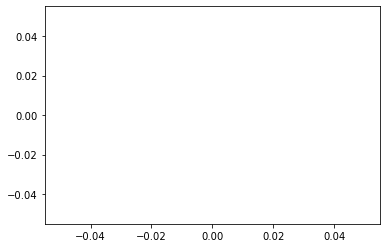

In [42]:
plt.plot(xblock[100:201][5])

In [43]:
f = xblock

In [44]:
X = f[:T-1,:,:]
y = f[1:,:,:]

In [45]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [46]:
for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X,y)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [01:32<00:00,  1.85s/it]


In [47]:
yhat = torch.stack([model(xt, edge_index, edge_attr) for xt in X]).detach().numpy()

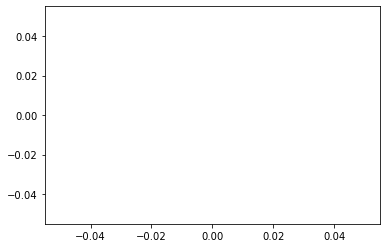

In [48]:
plt.plot(yhat[100:201][5].data)

# 1. missing을 채움. (mean, linear interpolation) 

In [128]:
xrandom_mean = xrandom.clone()

In [135]:
lst=[]
for i in range(100,201):
    lst.append(xrandom_mean[i].mean().tolist())

In [143]:
xrandom_mean[100:201][5] = torch.tensor(lst,dtype=torch.float32)

RuntimeError: The expanded size of the tensor (1) must match the existing size (101) at non-singleton dimension 1.  Target sizes: [20, 1].  Tensor sizes: [101]

In [ ]:
df = pd.DataFrame(xrandom_mean[5].tolist())
mean_value = df.mean() # finds the mean value of the column A
df = df.fillna(mean_value) # replace missing values with the mean value

In [ ]:
xrandom_mean[5] = torch.Tensor(df.values)

In [ ]:
plt.plot(xrandom_mean[5])

## 1.2. linear interpolation

### 1) Block

In [130]:
xblock_linearinterpolation = xblock.clone()

In [ ]:
xblock_linearinterpolation[100:201][5]

In [ ]:
# Sample data points
x = np.array([499,1000])
y = np.array([xblock_linearinterpolation[5][499],xblock_linearinterpolation[5][1000]])

# Create interpolating function
f = interp1d(x, y, kind='linear')

# Estimate y value for x = 2.5
y_interp = f(range(500,1000))

In [ ]:
xblock_linearinterpolation[5][500:1000] = torch.Tensor(y_interp).reshape(500,1)

In [ ]:
plt.plot(xblock_linearinterpolation[5])

### 2) Random missing values

In [ ]:
xrandom_linearinterpolation = xrandom.clone()

In [ ]:
df = pd.DataFrame(xrandom_linearinterpolation[5].tolist())
df.interpolate(method='linear', inplace=True)
df = df.fillna(0)

In [ ]:
xrandom_linearinterpolation[5] = torch.Tensor(df.values)

In [ ]:
plt.plot(xrandom_linearinterpolation[5])

### 3) By 2

In [ ]:
xtwo_linearinterpolation = xtwo.clone()

In [ ]:
df = pd.DataFrame(xtwo_linearinterpolation[5].tolist())
df.interpolate(method='linear', inplace=True)
df = df.fillna(0)

In [ ]:
xtwo_linearinterpolation[5] = torch.Tensor(df.values)

In [ ]:
plt.plot(xtwo_linearinterpolation[5])

## 1.3. Normal distribution Random Values

### 1) Block

In [ ]:
xblock_normal = xblock.clone()

In [ ]:
xblock_normal[5][500:1000] = torch.tensor(np.random.normal(loc=0,scale=0.2,size=500)).reshape(500,1)

In [ ]:
plt.plot(xblock_normal[5])

### 2) Random missing values

In [ ]:
xrandom_normal = xrandom.clone()

In [ ]:
xrandom_normal[5][seed_number] = torch.tensor(np.random.normal(loc=0,scale=0.2,size=500),dtype=torch.float32).reshape(500,1)

In [ ]:
plt.plot(xrandom_normal[5])

### 3) By 2

In [ ]:
xtwo_normal = xtwo.clone()

In [ ]:
xtwo_normal[5][two_number] = torch.tensor(np.random.normal(loc=0,scale=0.2,size=534),dtype=torch.float32).reshape(534,1)

In [ ]:
plt.plot(xtwo_normal[5])

# 2. ST-GCN 을 사용하여 fhat을 구함. (스무딩1) 

## 2.1. Mean

### 1) Block

In [ ]:
f_xblock_mean = xblock_mean.clone()

In [ ]:
X_f_xblock_mean = f_xblock_mean[:728,:,:]
y_f_xblock_mean = f_xblock_mean[1:,:,:]

In [ ]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X_f_xblock_mean,y_f_xblock_mean)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

In [ ]:
fhat_xblock_mean = torch.stack([model(xt, edge_index, edge_attr) for xt in X_f_xblock_mean]).detach().numpy()

In [ ]:
plt.plot(fhat_xblock_mean[5].data)

### 2) Random missing values

In [ ]:
f_xrandom_mean = xrandom_mean.clone()

In [ ]:
X_f_xrandom_mean = f_xrandom_mean[:728,:,:]
y_f_xrandom_mean = f_xrandom_mean[1:,:,:]

In [ ]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X_f_xrandom_mean,y_f_xrandom_mean)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

In [ ]:
fhat_xrandom_mean = torch.stack([model(xt, edge_index, edge_attr) for xt in X_f_xrandom_mean]).detach().numpy()

In [ ]:
plt.plot(fhat_xrandom_mean[5].data)

### 3) By 2

In [ ]:
f_xtwo_mean = xtwo_mean.clone()

In [ ]:
X_f_xtwo_mean = f_xtwo_mean[:728,:,:]
y_f_xtwo_mean = f_xtwo_mean[1:,:,:]

In [ ]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X_f_xtwo_mean,y_f_xtwo_mean)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

In [ ]:
fhat_xtwo_mean = torch.stack([model(xt, edge_index, edge_attr) for xt in X_f_xtwo_mean]).detach().numpy()

In [ ]:
plt.plot(fhat_xtwo_mean[5].data)

## 2.2. linear interpolation

### 1) Block

In [ ]:
f_block_linearinterpolation = xblock_linearinterpolation.clone()

In [ ]:
X_f_block_linearinterpolation = f_block_linearinterpolation[:728,:,:]
y_f_block_linearinterpolation = f_block_linearinterpolation[1:,:,:]

In [ ]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X_f_block_linearinterpolation,y_f_block_linearinterpolation)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

In [ ]:
fhat_linearinterpolation = torch.stack([model(xt, edge_index, edge_attr) for xt in X_f_block_linearinterpolation]).detach().numpy()

In [ ]:
plt.plot(fhat_linearinterpolation[:,2].data)

### 2) Random missing values

In [ ]:
f_random_linearinterpolation = xrandom_linearinterpolation.clone()

In [ ]:
X_f_random_linearinterpolation = f_random_linearinterpolation[:728,:,:]
y_f_random_linearinterpolation = f_random_linearinterpolation[1:,:,:]

In [ ]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X_f_random_linearinterpolation,y_f_random_linearinterpolation)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

In [ ]:
fhat_random_linearinterpolation = torch.stack([model(xt, edge_index, edge_attr) for xt in X_f_random_linearinterpolation]).detach().numpy()

In [ ]:
plt.plot(fhat_random_linearinterpolation[5].data)

### 3) By 2

In [ ]:
f_two_linearinterpolation = xtwo_linearinterpolation.clone()

In [ ]:
X_f_two_linearinterpolation = f_two_linearinterpolation[:728,:,:]
y_f_two_linearinterpolation = f_two_linearinterpolation[1:,:,:]

In [ ]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X_f_two_linearinterpolation,y_f_two_linearinterpolation)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

In [ ]:
fhat_two_linearinterpolation = torch.stack([model(xt, edge_index, edge_attr) for xt in X_f_two_linearinterpolation]).detach().numpy()

In [ ]:
plt.plot(fhat_two_linearinterpolation[5].data)

## 2.3. Normal distribution Random Values

### 1) Block

In [ ]:
f_xblock_normal = xblock_normal.clone()

In [ ]:
X_f_xblock_normal = f_xblock_normal[:728,:,:]
y_f_xblock_normal = f_xblock_normal[1:,:,:]

In [ ]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X_f_xblock_normal,y_f_xblock_normal)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

In [ ]:
fhat_xblock_normal = torch.stack([model(xt, edge_index, edge_attr) for xt in X_f_xblock_normal]).detach().numpy()

In [ ]:
plt.plot(fhat_xblock_normal[5].data)

### 2) Random missing values

In [ ]:
f_xrandom_normal = xrandom_normal.clone()

In [ ]:
X_f_xrandom_normal = f_xrandom_normal[:728,:,:]
y_f_xrandom_normal = f_xrandom_normal[1:,:,:]

In [ ]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X_f_xrandom_normal,y_f_xrandom_normal)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

In [ ]:
fhat_xrandom_normal = torch.stack([model(xt, edge_index, edge_attr) for xt in X_f_xrandom_normal]).detach().numpy()

In [ ]:
plt.plot(f_xrandom_normal[5].data)

### 3) By 2

In [ ]:
f_xtwo_normal = xtwo_normal.clone()

In [ ]:
X_f_xtwo_normal = f_xtwo_normal[:728,:,:]
y_f_xtwo_normal = f_xtwo_normal[1:,:,:]

In [ ]:
model = RecurrentGCN(node_features=1, filters=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

model.train()

for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X_f_xtwo_normal,y_f_xtwo_normal)):
        y_hat = model(xt, edge_index, edge_attr)
        cost = torch.mean((y_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

In [ ]:
fhat_xtwo_normal = torch.stack([model(xt, edge_index, edge_attr) for xt in X_f_xtwo_normal]).detach().numpy()

In [ ]:
plt.plot(fhat_xtwo_normal[5].data)

# 3. 2에서 얻은 fhat을 이용하여 그래프퓨리에변환+Ebayesthresh (스무딩2)  

- 그래프퓨리에변환을 하는 가중치
- 년도끼리 이어주어서 하나의 큰 그래프로 만든뒤에 GFT 
- Ebayesthresh 

## 3.1. Mean

### 3.1.1. Temporal

#### 1) Block

In [ ]:
w=np.zeros((1068,728,728))

In [ ]:
for k in range(1068):
    for i in range(728):
        for j in range(728):
            if i==j :
                w[k,i,j] = 0
            elif np.abs(i-j) <= 1 : 
                w[k,i,j] = 1

In [ ]:
d = np.array([w[i].sum(axis=1) for i in range(1068)])
D= np.array([np.diag(d[i]) for i in range(1068)])
L = np.array([np.diag(1/np.sqrt(d[i])) @ (D[i]-w[i]) @ np.diag(1/np.sqrt(d[i])) for i in range(1068)])
lamb, Psi  = np.linalg.eigh(L)[0],np.linalg.eigh(L)[1]
Lamb = np.array([np.diag(lamb[i]) for i in range(1068)])    
fhatbar = np.hstack([Psi[i] @ fhat_xblock_mean[:,i] for i in range(1068)])
_fhatbar = fhatbar.reshape(1068,728)
power = _fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(_fhatbar[i]**2))) for i in range(1068)])
fhatbar_threshed = np.where(power_threshed>0,_fhatbar,0)
fhatbarhat = np.array([Psi[i] @ fhatbar_threshed[i] for i in range(1068)])    
fhatbarhat_block_mean_temporal = fhatbarhat.reshape(728,-1)

In [ ]:
plt.plot(fhatbarhat_block_mean_temporal[5])

#### 2) Random missing values

In [ ]:
d = np.array([w[i].sum(axis=1) for i in range(1068)])
D= np.array([np.diag(d[i]) for i in range(1068)])
L = np.array([np.diag(1/np.sqrt(d[i])) @ (D[i]-w[i]) @ np.diag(1/np.sqrt(d[i])) for i in range(1068)])
lamb, Psi  = np.linalg.eigh(L)[0],np.linalg.eigh(L)[1]
Lamb = np.array([np.diag(lamb[i]) for i in range(1068)])    
fhatbar = np.hstack([Psi[i] @ fhat_xrandom_mean[:,i] for i in range(1068)])
_fhatbar = fhatbar.reshape(1068,728)
power = _fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(_fhatbar[i]**2))) for i in range(1068)])
fhatbar_threshed = np.where(power_threshed>0,_fhatbar,0)
fhatbarhat = np.array([Psi[i] @ fhatbar_threshed[i] for i in range(1068)])    
fhatbarhat_random_mean_temporal = fhatbarhat.reshape(728,-1)

In [ ]:
plt.plot(fhatbarhat_random_mean_temporal[5])

#### 3) By 2

In [ ]:
d = np.array([w[i].sum(axis=1) for i in range(1068)])
D= np.array([np.diag(d[i]) for i in range(1068)])
L = np.array([np.diag(1/np.sqrt(d[i])) @ (D[i]-w[i]) @ np.diag(1/np.sqrt(d[i])) for i in range(1068)])
lamb, Psi  = np.linalg.eigh(L)[0],np.linalg.eigh(L)[1]
Lamb = np.array([np.diag(lamb[i]) for i in range(1068)])    
fhatbar = np.hstack([Psi[i] @ fhat_xtwo_mean[:,i] for i in range(1068)])
_fhatbar = fhatbar.reshape(1068,728)
power = _fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(_fhatbar[i]**2))) for i in range(1068)])
fhatbar_threshed = np.where(power_threshed>0,_fhatbar,0)
fhatbarhat = np.array([Psi[i] @ fhatbar_threshed[i] for i in range(1068)])    
fhatbarhat_two_mean_temporal = fhatbarhat.reshape(728,-1)

In [ ]:
plt.plot(fhatbarhat_two_mean_temporal[5])

### 3.1.2. Spatio

#### 1) Block

In [ ]:
w=np.zeros((1068,1068))

In [ ]:
for i in range(1068):
    for j in range(1068):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [ ]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_xblock_mean.reshape(1068,728)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(1068)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_xblock_mean_spatio = fhatbarhat.reshape(728,-1)

In [ ]:
plt.plot(fhatbarhat_xblock_mean_spatio[5])

#### 2) Random missing values

In [ ]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_xrandom_mean.reshape(1068,728)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(1068)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_xrandom_mean_spatio = fhatbarhat.reshape(728,-1)

In [ ]:
plt.plot(fhatbarhat_xrandom_mean_spatio[5])

#### 3) By 2

In [ ]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_xtwo_mean.reshape(1068,728)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(1068)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_xtwo_mean_spatio = fhatbarhat.reshape(728,-1)

In [ ]:
plt.plot(fhatbarhat_xtwo_mean_spatio[5])

### 3.1.3. Spatio-Temporal

#### 1) Block

In [ ]:
w=np.zeros((777504,777504))

In [ ]:
for i in range(777504):
    for j in range(777504):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [ ]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_xblock_mean.reshape(777504,1)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(777504)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_block_mean_spatio_temporal = fhatbarhat.reshape(728,1068,1)

In [ ]:
plt.plot(fhatbarhat_block_mean_spatio_temporal[5])

#### 2) Random missing values

In [ ]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_xrandom_mean.reshape(777504,1)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(777504)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_random_mean_spatio_temporal = fhatbarhat.reshape(728,1068,1)

In [ ]:
plt.plot(fhatbarhat_random_mean_spatio_temporal[5])

#### 3) By 2

In [ ]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_xtwo_mean.reshape(777504,1)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(777504)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_two_mean_spatio_temporal = fhatbarhat.reshape(728,1068,1)

In [ ]:
plt.plot(fhatbarhat_two_mean_spatio_temporal[5])

## 3.2.linear interpolation

### 3.2.1. Temporal

#### 1) Block

In [ ]:
w=np.zeros((N,728,728))

In [ ]:
for k in range(N):
    for i in range(728):
        for j in range(728):
            if i==j :
                w[k,i,j] = 0
            elif np.abs(i-j) <= 1 : 
                w[k,i,j] = 1

In [ ]:
d = np.array([w[i].sum(axis=1) for i in range(N)])
D= np.array([np.diag(d[i]) for i in range(N)])
L = np.array([np.diag(1/np.sqrt(d[i])) @ (D[i]-w[i]) @ np.diag(1/np.sqrt(d[i])) for i in range(N)])
lamb, Psi  = np.linalg.eigh(L)[0],np.linalg.eigh(L)[1]
Lamb = np.array([np.diag(lamb[i]) for i in range(N)])
fhatbar = np.hstack([Psi[i] @ fhat_linearinterpolation[:,i] for i in range(N)])
_fhatbar = fhatbar.reshape(N,728)
power = _fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(_fhatbar[i]**2))) for i in range(N)])    
fhatbar_threshed = np.where(power_threshed>0,_fhatbar,0)
fhatbarhat = np.array([Psi[i] @ fhatbar_threshed[i] for i in range(N)])    
fhatbarhat_block_linearinterpolation_temporal = fhatbarhat.reshape(728,-1)

In [ ]:
plt.plot(fhatbarhat_block_linearinterpolation_temporal[5])

#### 2) Random missing values

In [ ]:
d = np.array([w[i].sum(axis=1) for i in range(N)])
D= np.array([np.diag(d[i]) for i in range(N)])
L = np.array([np.diag(1/np.sqrt(d[i])) @ (D[i]-w[i]) @ np.diag(1/np.sqrt(d[i])) for i in range(N)])
lamb, Psi  = np.linalg.eigh(L)[0],np.linalg.eigh(L)[1]
Lamb = np.array([np.diag(lamb[i]) for i in range(N)])
fhatbar = np.hstack([Psi[i] @ fhat_random_linearinterpolation[:,i] for i in range(N)])
_fhatbar = fhatbar.reshape(N,728)
power = _fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(_fhatbar[i]**2))) for i in range(N)])    
fhatbar_threshed = np.where(power_threshed>0,_fhatbar,0)
fhatbarhat = np.array([Psi[i] @ fhatbar_threshed[i] for i in range(N)])    
fhatbarhat_random_linearinterpolation_temporal = fhatbarhat.reshape(728,-1)

In [ ]:
plt.plot(fhatbarhat_random_linearinterpolation_temporal[5])

#### 3) By 2

In [ ]:
d = np.array([w[i].sum(axis=1) for i in range(N)])
D= np.array([np.diag(d[i]) for i in range(N)])
L = np.array([np.diag(1/np.sqrt(d[i])) @ (D[i]-w[i]) @ np.diag(1/np.sqrt(d[i])) for i in range(N)])
lamb, Psi  = np.linalg.eigh(L)[0],np.linalg.eigh(L)[1]
Lamb = np.array([np.diag(lamb[i]) for i in range(N)])
fhatbar = np.hstack([Psi[i] @ fhat_two_linearinterpolation[:,i] for i in range(N)])
_fhatbar = fhatbar.reshape(N,728)
power = _fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(_fhatbar[i]**2))) for i in range(N)])    
fhatbar_threshed = np.where(power_threshed>0,_fhatbar,0)
fhatbarhat = np.array([Psi[i] @ fhatbar_threshed[i] for i in range(N)])    
fhatbarhat_two_linearinterpolation_temporal = fhatbarhat.reshape(728,-1)

In [ ]:
plt.plot(fhatbarhat_two_linearinterpolation_temporal[5])

### 3.2.2. Spatio

#### 1) Block

In [ ]:
w=np.zeros((N,N))

In [ ]:
for i in range(N):
    for j in range(N):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [ ]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_linearinterpolation.reshape(N,728)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(N)])    
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_block_linearinterpolation_spatio = fhatbarhat.reshape(728,-1)

In [ ]:
plt.plot(fhatbarhat_block_linearinterpolation_spatio[5])

#### 2) Random missing values

In [ ]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_random_linearinterpolation.reshape(N,728)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(N)])    
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_random_linearinterpolation_spatio = fhatbarhat.reshape(728,-1)

In [ ]:
plt.plot(fhatbarhat_random_linearinterpolation_spatio[5])

#### 3) By 2

In [ ]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_two_linearinterpolation.reshape(N,728)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(N)])    
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_two_linearinterpolation_spatio = fhatbarhat.reshape(728,-1)

In [ ]:
plt.plot(fhatbarhat_two_linearinterpolation_spatio[5])

### 3.2.3. Spatio-Temporal

#### 1) Block

In [ ]:
w=np.zeros((777504,777504))

In [ ]:
for i in range(777504):
    for j in range(777504):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [ ]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_linearinterpolation.reshape(777504,1)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(777504)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhat_block_linearinterpolation_spatio_temporal = fhatbarhat.reshape(728,N,1)

In [ ]:
plt.plot(fhat_block_linearinterpolation_spatio_temporal[5])

#### 2) Random missing values

In [ ]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_random_linearinterpolation.reshape(777504,1)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(777504)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhat_random_linearinterpolation_spatio_temporal = fhatbarhat.reshape(728,N,1)

In [ ]:
plt.plot(fhat_random_linearinterpolation_spatio_temporal[5])

#### 3) By 2

In [ ]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_two_linearinterpolation.reshape(777504,1)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(777504)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhat_two_linearinterpolation_spatio_temporal = fhatbarhat.reshape(728,N,1)

In [ ]:
plt.plot(fhat_two_linearinterpolation_spatio_temporal[5])

## 3.3. Normal distribution

### 3.3.1. Temporal

#### 1) Block

In [ ]:
w=np.zeros((N,728,728))

In [ ]:
for k in range(N):
    for i in range(728):
        for j in range(728):
            if i==j :
                w[k,i,j] = 0
            elif np.abs(i-j) <= 1 : 
                w[k,i,j] = 1

In [ ]:
d = np.array([w[i].sum(axis=1) for i in range(N)])
D= np.array([np.diag(d[i]) for i in range(N)])
L = np.array([np.diag(1/np.sqrt(d[i])) @ (D[i]-w[i]) @ np.diag(1/np.sqrt(d[i])) for i in range(N)])
lamb, Psi  = np.linalg.eigh(L)[0],np.linalg.eigh(L)[1]
Lamb = np.array([np.diag(lamb[i]) for i in range(N)])    
fhatbar = np.hstack([Psi[i] @ fhat_xblock_normal[:,i] for i in range(N)])
_fhatbar = fhatbar.reshape(N,728)
power = _fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(_fhatbar[i]**2))) for i in range(N)])
fhatbar_threshed = np.where(power_threshed>0,_fhatbar,0)
fhatbarhat = np.array([Psi[i] @ fhatbar_threshed[i] for i in range(N)])    
fhatbarhat_block_normal_temporal = fhatbarhat.reshape(728,-1)

In [ ]:
plt.plot(fhatbarhat_block_normal_temporal[5])

#### 2) Random missing values

In [ ]:
d = np.array([w[i].sum(axis=1) for i in range(N)])
D= np.array([np.diag(d[i]) for i in range(N)])
L = np.array([np.diag(1/np.sqrt(d[i])) @ (D[i]-w[i]) @ np.diag(1/np.sqrt(d[i])) for i in range(N)])
lamb, Psi  = np.linalg.eigh(L)[0],np.linalg.eigh(L)[1]
Lamb = np.array([np.diag(lamb[i]) for i in range(N)])    
fhatbar = np.hstack([Psi[i] @ fhat_xrandom_normal[:,i] for i in range(N)])
_fhatbar = fhatbar.reshape(N,728)
power = _fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(_fhatbar[i]**2))) for i in range(N)])
fhatbar_threshed = np.where(power_threshed>0,_fhatbar,0)
fhatbarhat = np.array([Psi[i] @ fhatbar_threshed[i] for i in range(N)])    
fhatbarhat_random_normal_temporal = fhatbarhat.reshape(728,-1)

In [ ]:
plt.plot(fhatbarhat_block_normal_temporal[5])

#### 3) By 2

In [ ]:
d = np.array([w[i].sum(axis=1) for i in range(N)])
D= np.array([np.diag(d[i]) for i in range(N)])
L = np.array([np.diag(1/np.sqrt(d[i])) @ (D[i]-w[i]) @ np.diag(1/np.sqrt(d[i])) for i in range(N)])
lamb, Psi  = np.linalg.eigh(L)[0],np.linalg.eigh(L)[1]
Lamb = np.array([np.diag(lamb[i]) for i in range(N)])    
fhatbar = np.hstack([Psi[i] @ fhat_xtwo_normal[:,i] for i in range(N)])
_fhatbar = fhatbar.reshape(N,728)
power = _fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(_fhatbar[i]**2))) for i in range(N)])
fhatbar_threshed = np.where(power_threshed>0,_fhatbar,0)
fhatbarhat = np.array([Psi[i] @ fhatbar_threshed[i] for i in range(N)])    
fhatbarhat_two_normal_temporal = fhatbarhat.reshape(728,-1)

In [ ]:
plt.plot(fhatbarhat_two_normal_temporal[5])

### 3.3.2. Spatio

#### 1) Block

In [ ]:
w=np.zeros((N,N))

In [ ]:
for i in range(N):
    for j in range(N):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [ ]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_xblock_normal.reshape(N,728)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(N)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_block_normal_spatio = fhatbarhat.reshape(728,-1)

In [ ]:
plt.plot(fhatbarhat_block_normal_spatio[5])

#### 2) Random missing values

In [ ]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_xrandom_normal.reshape(N,728)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(N)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_random_normal_spatio = fhatbarhat.reshape(728,-1)

In [ ]:
plt.plot(fhatbarhat_random_normal_spatio[5])

#### 3) By 2

In [ ]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_xrandom_normal.reshape(N,728)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(N)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_random_normal_spatio = fhatbarhat.reshape(728,-1)

In [ ]:
plt.plot(fhatbarhat_random_normal_spatio[5])

### 3.3.3. Spatio-Temporal

#### 1) Block

In [ ]:
w=np.zeros((777504,777504))

In [ ]:
for i in range(777504):
    for j in range(777504):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [ ]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_xblock_normal.reshape(777504,1)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(777504)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_block_normal_spatio_temporal = fhatbarhat.reshape(777504,N,1)

In [ ]:
plt.plot(fhatbarhat_normal_spatio_temporal[5])

#### 2) Random missing values

In [ ]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_xrandom_normal.reshape(777504,1)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(777504)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_random_normal_spatio_temporal = fhatbarhat.reshape(777504,N,1)

In [ ]:
plt.plot(fhatbarhat_random_normal_spatio_temporal[5])

#### 3) By 2

In [ ]:
d = np.array(w.sum(axis=1))
D = np.diag(d)
L = np.array(np.diag(1/np.sqrt(d)) @ (D-w) @ np.diag(1/np.sqrt(d)))
lamb, Psi = np.linalg.eigh(L)
Lamb = np.diag(lamb)
fhatbar = Psi @ fhat_xtwo_normal.reshape(777504,1)
power = fhatbar**2 
ebayesthresh = importr('EbayesThresh').ebayesthresh
power_threshed=np.array([np.array(ebayesthresh(FloatVector(fhatbar[i]**2))) for i in range(777504)])
fhatbar_threshed = np.where(power_threshed>0,fhatbar,0)
fhatbarhat = Psi @ fhatbar_threshed
fhatbarhat_two_normal_spatio_temporal = fhatbarhat.reshape(777504,N,1)

In [ ]:
plt.plot(fhatbarhat_two_normal_spatio_temporal[5])

# 4. 1로 돌아가서 반복 